# [NTDS'18] milestone 4: solution
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838?lang=en), [EPFL LTS2](http://lts2.epfl.ch)

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

## 0 - Load your network

In [4]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

#from scipy import sparse, spatial
#from pygsp import graphs, filters, plotting

In [5]:
%matplotlib inline

For this milestone, all we will need are the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while following milestone 3, as well as a set of features/labels for each of the nodes on the network.

In this solution, we will work with a toy Stochastic Block Bodel ([SBM](https://en.wikipedia.org/wiki/Stochastic_block_model)) network, whose labels are the cluster indicator functions.

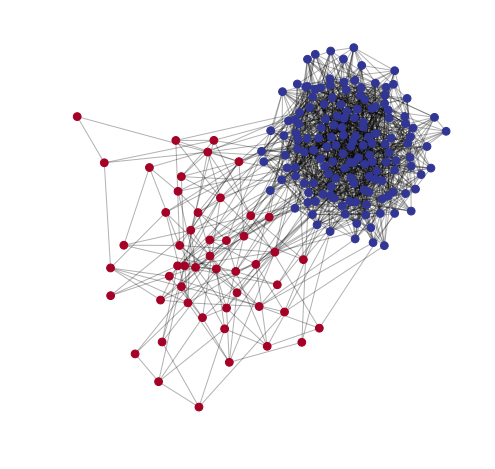

In [44]:
import networkx as nx

np.random.RandomState(seed=42)

G = nx.random_partition_graph(sizes=[150,50],p_in=.1, p_out=.01)

labels = np.ones((len(G)))
labels[150:] = 0.
pos = nx.spring_layout(G)  # compute graph layout

In [97]:
N = len(G)
A = nx.adjacency_matrix(G).tocsr()
d = np.asarray(np.power(A.sum(axis=1), -0.5)).squeeze()
D = sparse.diags(np.ravel(d), 0).tocsr()
L = sparse.identity(N) - D * A * D

v_in, v_out = sparse.tril(A).nonzero()
weights = A[v_in, v_out]
weights = np.asarray(weights).squeeze()

n = len(v_in)
Dr = np.concatenate((np.arange(n), np.arange(n)))
Dc = np.empty(2*n)
Dc[:n] = v_in
Dc[n:] = v_out
Dv = np.empty(2*n)

Dv[:n] = np.sqrt(weights / d[v_in])
Dv[n:] = -np.sqrt(weights / d[v_out])
nabla_G = sparse.csc_matrix((Dv, (Dr, Dc)), shape=(n, N))

In [98]:
laplacian = L
gradient = nabla_G
features = labels
n_nodes = N

## 1 - Graph Fourier Transform
- Compute Fourier basis (G.e, G.U)
- Visualize a couple of eigenvectors on the spectral embedding (a couple of low frequency ones, and a couple of high-frequency ones)
- Visualize some label signal on the graph
- Plot the GFT of this label signal.
- Discuss amplitude of GFT vis-a-vis similarity between label signal and eigenvectors.

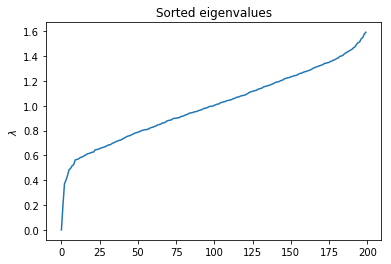

In [139]:
# Computing Fourier basis
U, s, _ = np.linalg.svd(L.toarray())
indices = np.argsort(s)
s = s[indices]
U = U[:, indices]
plt.plot(s)
plt.ylabel(r'$\lambda$')
plt.title('Sorted eigenvalues')
plt.show()

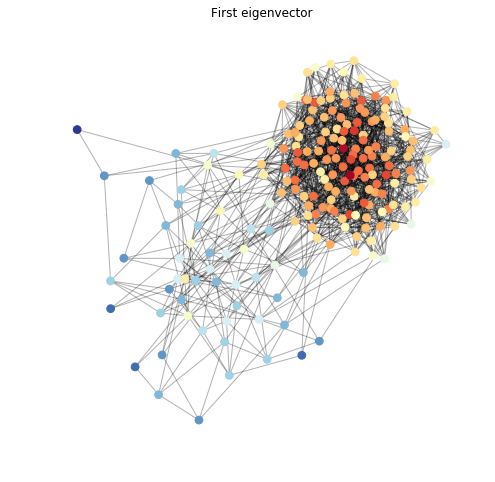

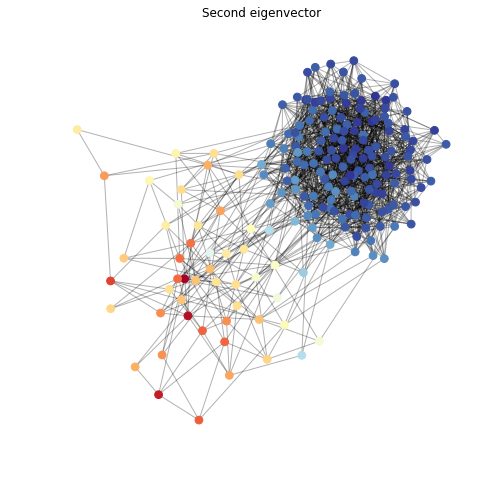

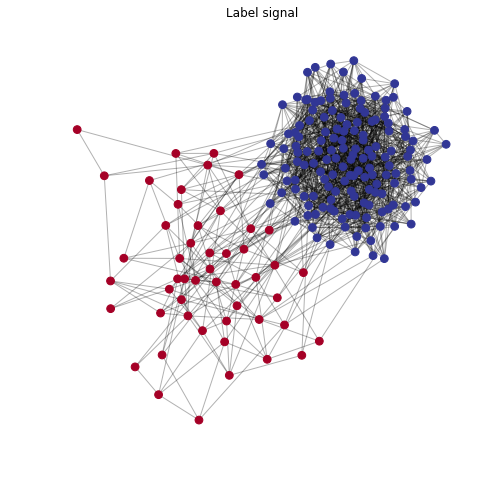

In [137]:
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(U[:,0]))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('First eigenvector')

plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(U[:,1]))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Second eigenvector')

plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(labels))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Label signal')
plt.show(G)

In [183]:
def GFT(x):
    return np.dot(U.transpose(), x)

def iGFT(x):
    return np.dot(U, x)

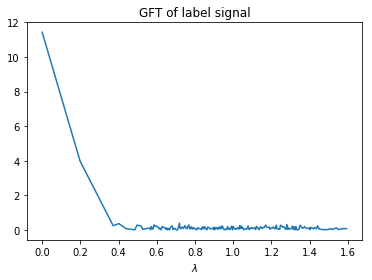

In [135]:
plt.plot(s, np.abs(GFT(labels)))
plt.title('GFT of label signal')
plt.xlabel(r'$\lambda$')
plt.show()

## 2 - Filtering on graphs
- Implement heat kernel f = filters.Heat(G, tau=10). 
- Plot the filters in the spectral domain.
- Plot localization of filtered Diracs and compare with Laplacian vs. heat diffusion.

In [229]:
def heat_kernel(f, tau=1.):
    return np.exp(-tau * f)
    
def inverse_kernel(f, tau=1.):
    return 1./(1 + tau * f)

def rectangle_kernel(f, lambda_min=0., lambda_max=2.):
    return (np.greater_equal(f, lambda_min) * np.less_equal(f, lambda_max)).astype(float)

def graph_filter(x, kernel, **kwargs):
    return iGFT(np.diag(kernel(s, **kwargs)).dot(GFT(x)))

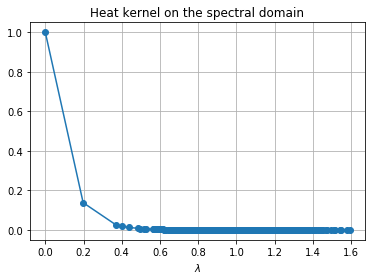

In [214]:
plt.plot(s, heat_kernel(s, tau=10.), '-o')
plt.title('Heat kernel on the spectral domain')
plt.xlabel(r'$\lambda$')
plt.grid('on')
plt.show()

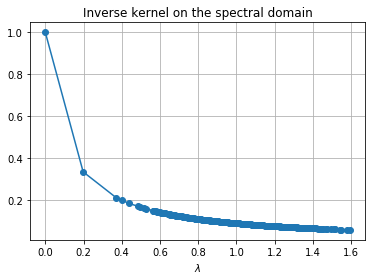

In [215]:
plt.plot(s, inverse_kernel(s, tau=10.), '-o')
plt.title('Inverse kernel on the spectral domain')
plt.xlabel(r'$\lambda$')
plt.grid('on')
plt.show()

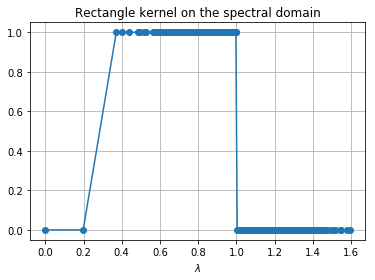

In [231]:
plt.plot(s, rectangle_kernel(s, lambda_min=0.2, lambda_max=1.0), '-o')
plt.title('Rectangle kernel on the spectral domain')
plt.xlabel(r'$\lambda$')
plt.grid('on')
plt.show()

## 3 - De-noising 
(Note: this task and the following assume that the label signal is low-pass on the graph frequencies. This is also known by the phrase "smoothness hypothesis" in semi-supervised learning)
- $x = y + \eta$ noisy measurements.
- Assumption: $x$ is "smooth", in the sense that $\|L x\|_2$ is small.
- $\text{arg} \, \underset{x\in \mathbb{R}^{n}}{\min} \|x - y\|^2 + \gamma x^{\top} L x$
- Derive closed form solution as a graph filtering operation. Implementation with `np.linalg.solve()`.
- Add noise to label and try to recover it (compare heavy-tailed vs. Gaussian noise?)
- Choose $\gamma$ based on the GFT of the label signal and the spectral representation of the inverse kernel.
- Denoise the signal using heat diffusion. Choose the diffusion parameter based on the GFT of the label signal.
- Compare GFT of noisy and recovered signal for both cases. What do you observe?

In [279]:
# Adding noise to the signal
sigma = 0.2
x = labels + sigma * np.random.randn(N)

# Denoising with inverse kernel
x_inv_denoised = graph_filter(x, inverse_kernel, tau=5.)

# Denoising with heat kernel
x_heat_denoised = graph_filter(x, heat_kernel, tau=5.)

# Denoising with rectangle kernel
x_rect_denoised = graph_filter(x, rectangle_kernel, lambda_max=0.4)

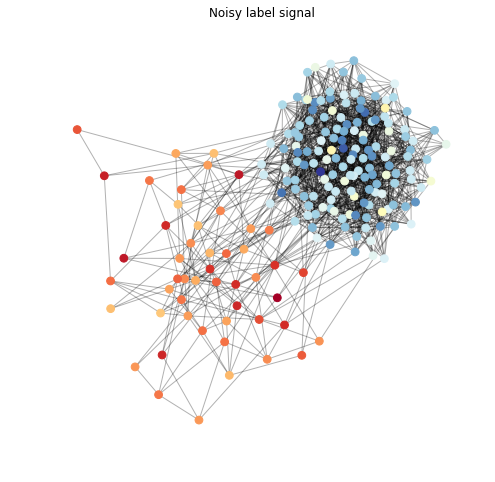

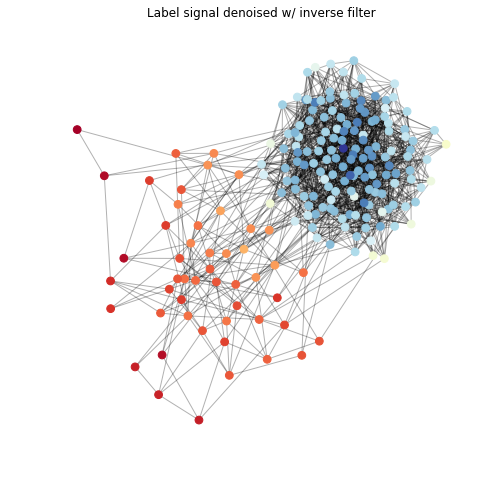

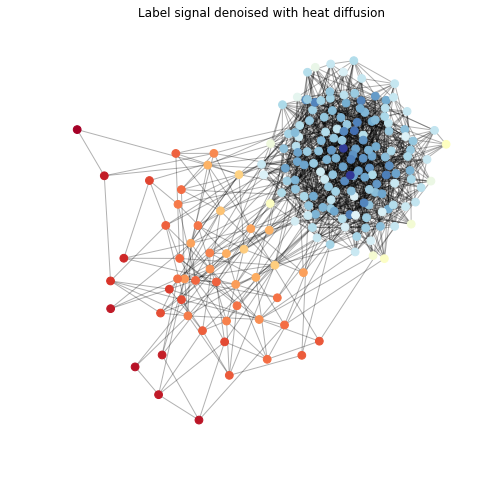

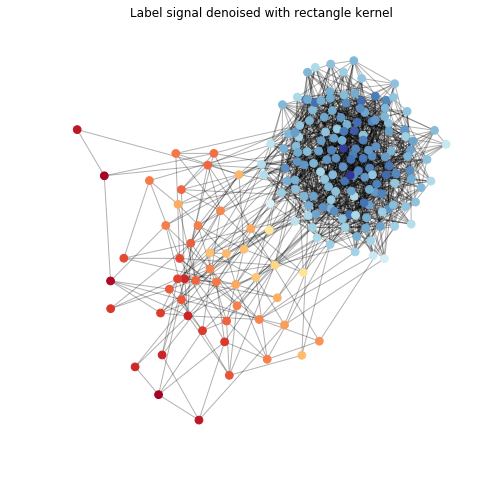

In [280]:
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(x))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Noisy label signal')

plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(x_inv_denoised))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Label signal denoised w/ inverse filter')

plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(x_heat_denoised))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Label signal denoised with heat diffusion')

plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(x_rect_denoised))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Label signal denoised with rectangle kernel')
plt.show(G)

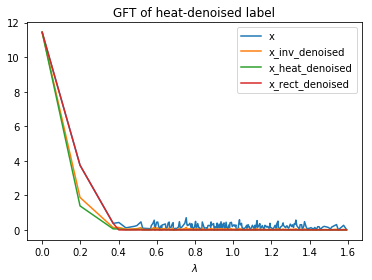

In [251]:
p1 = plt.plot(s, np.abs(GFT(x)))
plt.title('GFT of noisy label')
plt.xlabel(r'$\lambda$')

p2 = plt.plot(s, np.abs(GFT(x_inv_denoised)))
plt.title('GFT of inverse-denoised label')
plt.xlabel(r'$\lambda$')

p3 = plt.plot(s, np.abs(GFT(x_heat_denoised)))
plt.title('GFT of heat-denoised label')
plt.xlabel(r'$\lambda$')

p4 = plt.plot(s, np.abs(GFT(x_rect_denoised)))
plt.title('GFT of heat-denoised label')
plt.xlabel(r'$\lambda$')

plt.legend((p1[0], p2[0], p3[0], p4[0]), ('x', 'x_inv_denoised', 'x_heat_denoised', 'x_rect_denoised'))
plt.show()

## 4 - Transductive learning
- $\text{arg} \, \underset{x|_S = y}{\min} f_L(x)$
- Subsample your label signal.
- TL by minimizing quadratic form. Then, find a threshold.
- TL by minimizing graph total variation.
    - Relationship with graph cuts
- Compare those 2 approaches.
    - Phase transition on average error as function of thresholding parameter and m/n ratio.

For this task, you will need to install [pyunlocbox](https://pyunlocbox.readthedocs.io/en/stable/) in order to solve the variational problem that we have here. To do so, type
```sh
    pip install pyunlocbox
```
on the terminal, under the `ntds_2018` environment.

In [302]:
# Subsample the original signal

mn_ratio = 0.3
m = int(mn_ratio * N)

# Sample coordinates
sample_idx = np.random.choice(N, m, replace=False) # without replacement

# Implement sampling mask via point-wise multiplication
w = np.zeros(N,)
w[sample_idx] = 1. 

# Upsampled measurement vector for the interest of plotting 
y = np.nan * np.ones(N,)
y[sample_idx] = labels[sample_idx]

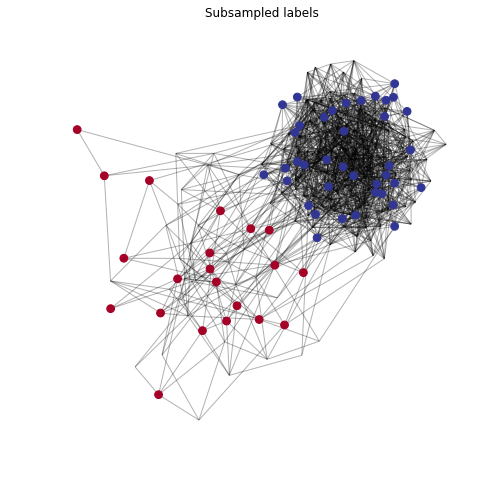

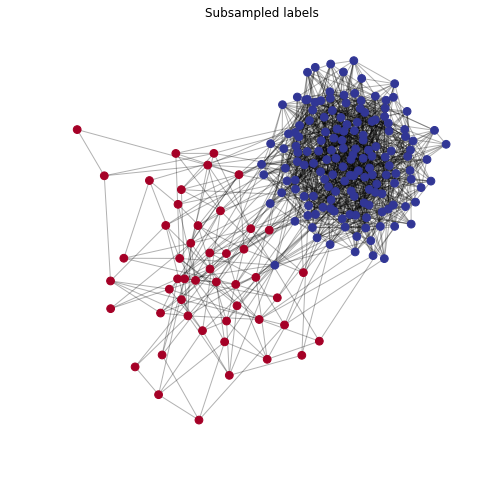

In [306]:
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(y))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Subsampled labels')

In [377]:
from pyunlocbox import functions, solvers


def graph_pnorm_interpolation(gradient, P, x0=None, p=1, **kwargs):
    r"""
    Solve an interpolation problem via graph gradient p-norm minimization.

    A graph signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p \text{ subject to } Az = y` via a primal-dual, forward-backward-forward algorithm.


    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : matrix or callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` onto the set satisfying :math:`A(z) = y`. It can be represented as a matrix or a callable function.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : 1 or 2
    **kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    problem : dict, optional
        Information about the the optimization process. it is the dictionary
        returned by :func:`pyunlocbox.solvers.solve`. The solution to the
        problem is found under the field `sol`.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)
    
    stepsize = 0.9 / (1. + scipy.sparse.linalg.norm(gradient, ord='fro'))
    
    if p == 1:
        solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2:
        solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize**2)
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

In [383]:
# Solve the graph TV problem with projections.
P = lambda z: ((1 - w) * z) + (w * labels)
x_1norm_rec = graph_pnorm_interpolation(gradient=gradient, P=P, x0=(w * labels), p=1,
                                    verbosity='LOW', 
                                    rtol=0, 
                                    maxit=5000)
x_2norm_rec = graph_pnorm_interpolation(gradient=gradient, P=P, x0=(w * labels), p=2,
                                    verbosity='LOW', 
                                    rtol=0, 
                                    maxit=5000)

# Renormalization
x_1norm_rec = (x_1norm_rec - np.min(x_1norm_rec)) / (np.max(x_1norm_rec) - np.min(x_1norm_rec))
x_2norm_rec = (x_2norm_rec - np.min(x_2norm_rec)) / (np.max(x_2norm_rec) - np.min(x_2norm_rec))

Solution found after 5000 iterations:
    objective function f(sol) = 1.931002e+02
    stopping criterion: MAXIT
Solution found after 5000 iterations:
    objective function f(sol) = 1.975920e+02
    stopping criterion: MAXIT


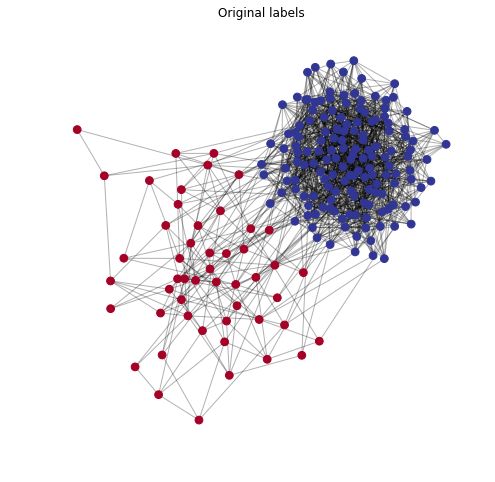

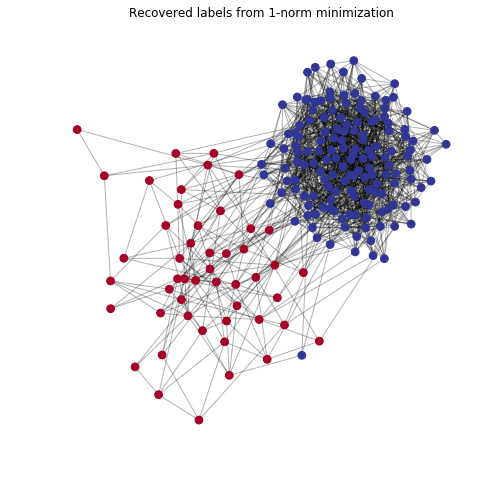

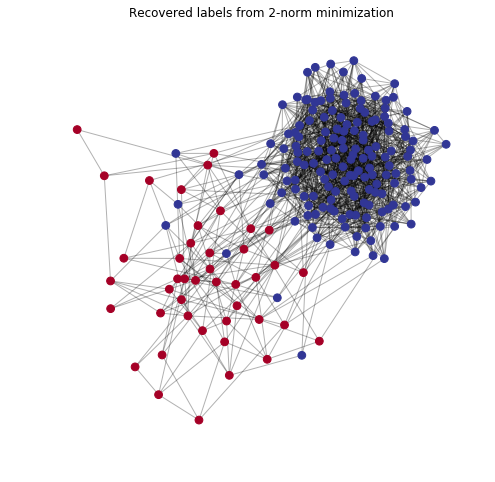

In [385]:
plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(labels))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Original labels')
plt.show()

plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(x_1norm_rec >= .5))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Recovered labels from 1-norm minimization')
plt.show()

plt.figure(figsize=(8, 8))  # image is 8 x 8 inches
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=60, cmap=plt.cm.RdYlBu, node_color=list(x_2norm_rec >= .5))
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title('Recovered labels from 2-norm minimization')
plt.show()

## 5 - Takeaways